# Importación de bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torchaudio
import os
import json
import torch.nn.functional as F
import numpy as np
import pandas as pd

from huggingface_hub import hf_hub_download
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [ ]:
!pip freeze | grep -E "pandas|matplotlib|seaborn|torch|torchaudio|transformers|scikit-learn|numpy|random"

geopandas==1.0.1
matplotlib==3.10.0
matplotlib-inline==0.1.7
matplotlib-venn==1.1.2
numpy==2.0.2
pandas==2.2.2
pandas-datareader==0.10.0
pandas-gbq==0.28.0
pandas-stubs==2.2.2.240909
scikit-learn==1.6.1
seaborn==0.13.2
sentence-transformers==3.4.1
sklearn-pandas==2.2.0
torch @ https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchsummary==1.5.1
torchvision @ https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl
transformers==4.51.3


In [ ]:
!cat /proc/cpuinfo
!cat /proc/meminfo
!df -h
!nvidia-smi

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.160
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [ ]:
import sys
print(sys.version)

3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


# Obtención del dataset MELD y de los modelos

Dataset MELD

In [ ]:
HOME = os.getcwd()
!mkdir {HOME}/data
%cd {HOME}/data

/content/data


Texto

In [ ]:
hf_dataset_identifier = "pabloorlw/MELD_text"
filename = "MELD_text.zip"

file_path = hf_hub_download(
    repo_id=hf_dataset_identifier,
    filename=filename,
    repo_type="dataset",
)

!unzip -q {file_path}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


MELD_text.zip:   0%|          | 0.00/514k [00:00<?, ?B/s]

Audio

In [ ]:
hf_dataset_identifier = "pabloorlw/MELD_audio"
filename = "MELD_audio.zip"

file_path = hf_hub_download(
    repo_id=hf_dataset_identifier,
    filename=filename,
    repo_type="dataset",
)

!unzip -q {file_path}

MELD_audio.zip:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Modelos

In [ ]:
!mkdir {HOME}/models
%cd {HOME}/models

/content/models


Texto

In [ ]:
hf_model_identifier = "pabloorlw/text_model"
filename = "text_model.zip"

file_path = hf_hub_download(
    repo_id=hf_model_identifier,
    filename=filename,
    repo_type="model",
)

!unzip -q {file_path}

text_model.zip:   0%|          | 0.00/247M [00:00<?, ?B/s]

Audio

In [ ]:
hf_model_identifier = "pabloorlw/audio_model"
filename = "audio_model.zip"

file_path = hf_hub_download(
    repo_id=hf_model_identifier,
    filename=filename,
    repo_type="model",
)

!unzip -q {file_path}

%cd {HOME}

audio_model.zip:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

/content


# Configuración inicial

In [ ]:
COMMON_EMOTIONS = ['joy', 'sadness', 'anger', 'fear', 'surprise']

CSV_PATH = "data/MELD_text/test_sent_emo.csv"
AUDIO_DATA_DIR = "data/MELD_audio"

TEXT_MODEL_PATH = "models/text_model"
AUDIO_MODEL_PATH = "models/audio_model"

SAMPLE_RATE = 16000

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Evaluando el modelo de texto en MELD

In [ ]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(TEXT_MODEL_PATH)
text_model = DistilBertForSequenceClassification.from_pretrained(TEXT_MODEL_PATH)
text_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Cargar las etiquetas originales del modelo
with open(os.path.join(TEXT_MODEL_PATH, "label_encoder.json")) as f:
    label_info = json.load(f)

emotions_id2label = {int(k): v for k, v in label_info["id2label"].items()}
emotions_label2id = label_info["label2id"]

{0: 'sadness', 1: 'joy', 2: 'anger', 3: 'fear', 4: 'surprise'}
{'sadness': 0, 'joy': 1, 'anger': 2, 'fear': 3, 'surprise': 4}


In [ ]:
# Mapeo de Emotions a MELD
EMOTIONS_TO_MELD = {
    "joy": "joy",
    "sadness": "sadness",
    "anger": "anger",
    "fear": "fear",
    "surprise": "surprise"
}

MELD_LABELS = list(EMOTIONS_TO_MELD.values())
MELD_LABEL2ID = {label: i for i, label in enumerate(MELD_LABELS)}

['joy', 'sadness', 'anger', 'fear', 'surprise']
{'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'surprise': 4}


In [ ]:
# Cargar datos de texto de MELD
df = pd.read_csv(CSV_PATH)
X_test = df["Utterance"].tolist()
y_true_raw = df["Emotion"].tolist()

# Filtrar solo las emociones mapeables en X_test
filtered_texts, y_true = [], []
for text, label in zip(X_test, y_true_raw):
    if label in MELD_LABEL2ID:
        filtered_texts.append(text)
        # y_true tiene las IDs de las etiquetas MELD
        y_true.append(MELD_LABEL2ID[label])
X_test = filtered_texts

In [ ]:
# Predicción
def predict(model, tokenizer, texts):
    preds = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()
        preds.append(pred)
    return preds

# raw_preds tiene los IDs de las labels de Emotions
raw_preds = predict(text_model, tokenizer, X_test)

# Mapear predicciones de Emotions a MELD
mapped_preds = []
mapped_labels = []
for pred, true in zip(raw_preds, y_true):
    pred_label = emotions_id2label[pred]
    if pred_label in EMOTIONS_TO_MELD:
        mapped_preds.append(MELD_LABEL2ID[EMOTIONS_TO_MELD[pred_label]])
        mapped_labels.append(true)

              precision    recall  f1-score   support

         joy       0.54      0.67      0.60       402
     sadness       0.52      0.27      0.35       208
       anger       0.35      0.59      0.44       345
        fear       0.09      0.12      0.10        50
    surprise       0.52      0.05      0.08       281

    accuracy                           0.43      1286
   macro avg       0.40      0.34      0.32      1286
weighted avg       0.46      0.43      0.39      1286



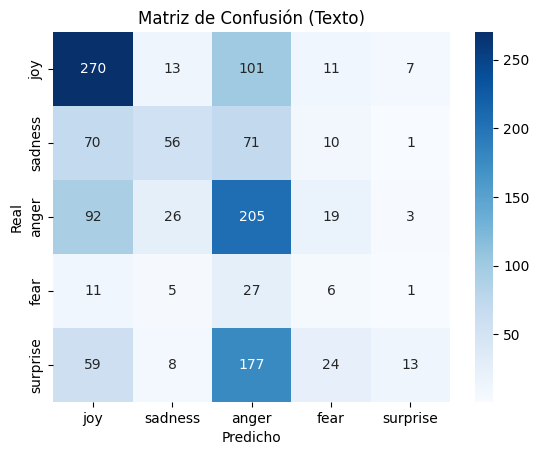

In [ ]:
# Reporte
print(classification_report(mapped_labels, mapped_preds, target_names=MELD_LABELS))

# Matriz de confusión
cm = confusion_matrix(mapped_labels, mapped_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=MELD_LABELS, yticklabels=MELD_LABELS, cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión (Texto)")
plt.show()

# Evaluando el modelo de audio en MELD

In [ ]:
# Feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(AUDIO_MODEL_PATH)
audio_model = Wav2Vec2ForSequenceClassification.from_pretrained(AUDIO_MODEL_PATH)
audio_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio_model.to(device)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=

In [ ]:
# Cargar las etiquetas originales del modelo
with open(os.path.join(AUDIO_MODEL_PATH, "label_encoder.json")) as f:
    label_info = json.load(f)

ravdess_label2id = label_info
ravdess_id2label = {v: k for k, v in ravdess_label2id.items()}

In [ ]:
# Mapeo de RAVDESS a MELD
RAVDESS_TO_MELD = {
    "happy": "joy",
    "sad": "sadness",
    "angry": "anger",
    "fearful": "fear",
    "surprised": "surprise"
}
MELD_LABELS = list(RAVDESS_TO_MELD.values())
MELD_LABEL2ID = {label: i for i, label in enumerate(MELD_LABELS)}

In [ ]:
# Cargar datos de audio MELD
df = pd.read_csv(CSV_PATH)
X_paths, y_true = [], []
for _, row in df.iterrows():
    file_name = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.wav"
    path = AUDIO_DATA_DIR + "/test/" + file_name
    if row["Emotion"] in MELD_LABEL2ID:
        X_paths.append(path)
        y_true.append(MELD_LABEL2ID[row["Emotion"]])

In [ ]:
# Predicción
def predict_audio(model, extractor, paths):
    preds = []
    for path in paths:
        waveform, sr = torchaudio.load(path)
        if sr != SAMPLE_RATE:
            waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
        inputs = extractor(waveform.squeeze().numpy(), sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()
        preds.append(pred)
    return preds

raw_preds = predict_audio(audio_model, feature_extractor, X_paths)

# Mapear predicciones de RAVDESS a MELD
mapped_preds, mapped_labels = [], []
for pred, true in zip(raw_preds, y_true):
    pred_label = ravdess_id2label[pred]
    if pred_label in RAVDESS_TO_MELD:
        mapped_preds.append(MELD_LABEL2ID[RAVDESS_TO_MELD[pred_label]])
        mapped_labels.append(true)

              precision    recall  f1-score   support

         joy       0.39      0.34      0.36       402
     sadness       0.31      0.14      0.20       208
       anger       0.51      0.28      0.36       345
        fear       0.06      0.20      0.10        50
    surprise       0.31      0.54      0.39       281

    accuracy                           0.33      1286
   macro avg       0.32      0.30      0.28      1286
weighted avg       0.38      0.33      0.33      1286



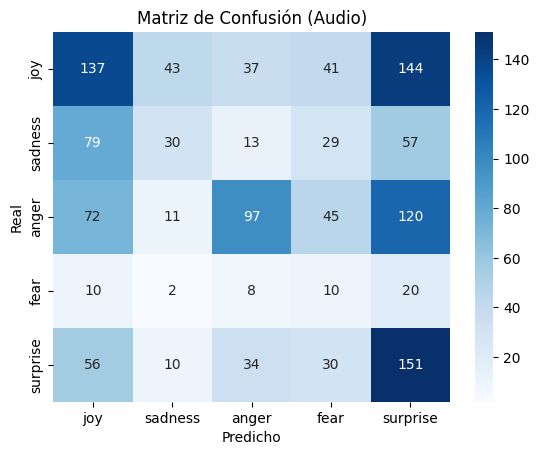

In [ ]:
# Reporte
print(classification_report(mapped_labels, mapped_preds, target_names=MELD_LABELS))

# Matriz de confusión
cm = confusion_matrix(mapped_labels, mapped_preds)
sns.heatmap(cm, annot=True, xticklabels=MELD_LABELS, yticklabels=MELD_LABELS, cmap="Blues", fmt="d")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión (Audio)")
plt.show()

# Estrategias de fusión multimodal

Obtención de las probabilidades de los modelos de texto y audio

In [ ]:
def get_text_probs(model, tokenizer, texts):
    probs = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        prob = F.softmax(logits, dim=1).squeeze().cpu().numpy()
        probs.append(prob)
    return np.array(probs)

print(get_text_probs(text_model, tokenizer,["This is a fantastic test."]))

text_probs = get_text_probs(text_model, tokenizer, X_test)

[[2.8685492e-04 9.9804521e-01 1.8482597e-04 1.9305697e-04 1.2899494e-03]]


In [ ]:
def get_audio_probs(model, extractor, paths):
    probs = []
    for path in paths:
        waveform, sr = torchaudio.load(path)
        if sr != SAMPLE_RATE:
            waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
        inputs = extractor(waveform.squeeze().numpy(), sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        prob = F.softmax(logits, dim=1).squeeze().cpu().numpy()
        probs.append(prob)
    return np.array(probs)

print(get_audio_probs(audio_model, feature_extractor, [AUDIO_DATA_DIR + "/test/dia134_utt3.wav"]))

audio_probs = get_audio_probs(audio_model, feature_extractor, X_paths)

[[9.9341571e-01 3.0134798e-03 6.4934517e-04 1.1692795e-03 1.7521697e-03]]


Fusión mediante voto mayoritario

              precision    recall  f1-score   support

         joy       0.17      0.08      0.11       402
     sadness       0.16      0.24      0.19       208
       anger       0.32      0.31      0.31       345
        fear       0.05      0.08      0.06        50
    surprise       0.37      0.48      0.42       281

    accuracy                           0.26      1286
   macro avg       0.21      0.24      0.22      1286
weighted avg       0.25      0.26      0.24      1286



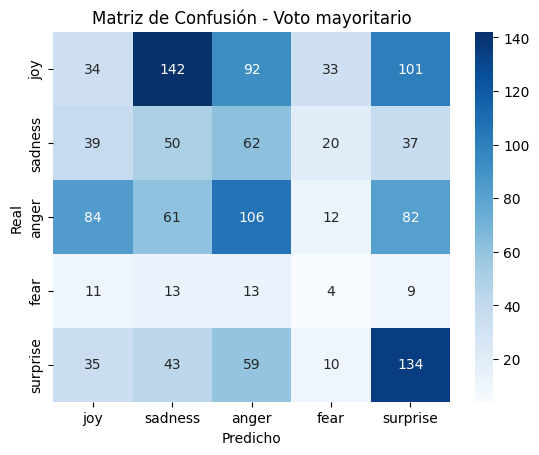

In [ ]:
def majority_voting_fusion(text_probs, audio_probs):
    text_preds = np.argmax(text_probs, axis=1)
    audio_preds = np.argmax(audio_probs, axis=1)
    fused_preds = []
    for i in range(len(text_preds)):
        if text_preds[i] == audio_preds[i]:
            fused_preds.append(text_preds[i])
        else:
            # ssi hay desacuerdo, comparamos las probabilidades maxs
            text_max_prob = np.max(text_probs[i])
            audio_max_prob = np.max(audio_probs[i])
            if text_max_prob > audio_max_prob:
                fused_preds.append(text_preds[i])
            elif audio_max_prob > text_max_prob:
                fused_preds.append(audio_preds[i])
            else:
                # si las probabilidades maxs también son iguales,
                # elegimos texto por defecto
                fused_preds.append(text_preds[i])
    return fused_preds

y_pred = majority_voting_fusion(text_probs, audio_probs)

# Reporte
print(classification_report(mapped_labels, y_pred, target_names=MELD_LABELS))

# Matriz de confusión
cm = confusion_matrix(mapped_labels, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=MELD_LABELS, yticklabels=MELD_LABELS, cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión - Voto mayoritario")
plt.show()

Fusión mediante media aritmética

              precision    recall  f1-score   support

         joy       0.17      0.08      0.11       402
     sadness       0.16      0.24      0.19       208
       anger       0.32      0.32      0.32       345
        fear       0.04      0.06      0.05        50
    surprise       0.37      0.47      0.42       281

    accuracy                           0.26      1286
   macro avg       0.21      0.23      0.22      1286
weighted avg       0.25      0.26      0.24      1286



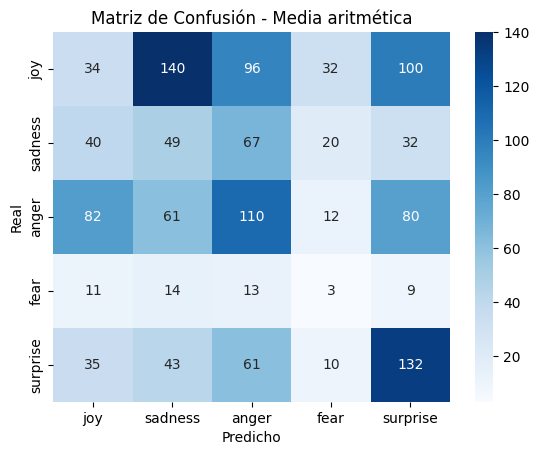

In [ ]:
def global_average_fusion(text_probs, audio_probs):
    fused_probs = (text_probs + audio_probs) / 2
    return np.argmax(fused_probs, axis=1)

y_pred = global_average_fusion(text_probs, audio_probs)

# Reporte
print(classification_report(mapped_labels, y_pred, target_names=MELD_LABELS))

# Matriz de confusión
cm = confusion_matrix(mapped_labels, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=MELD_LABELS, yticklabels=MELD_LABELS, cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión - Media aritmética")
plt.show()

Fusión mediante media ponderada


 Promedio ponderado con α = 0.2
              precision    recall  f1-score   support

         joy       0.18      0.08      0.12       402
     sadness       0.18      0.14      0.16       208
       anger       0.21      0.21      0.21       345
        fear       0.02      0.04      0.03        50
    surprise       0.31      0.53      0.39       281

    accuracy                           0.22      1286
   macro avg       0.18      0.20      0.18      1286
weighted avg       0.21      0.22      0.20      1286



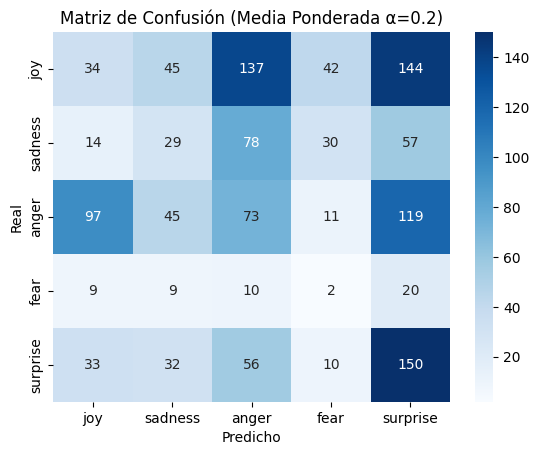


 Promedio ponderado con α = 0.6
              precision    recall  f1-score   support

         joy       0.16      0.05      0.08       402
     sadness       0.14      0.29      0.19       208
       anger       0.36      0.57      0.44       345
        fear       0.08      0.10      0.09        50
    surprise       0.41      0.17      0.24       281

    accuracy                           0.26      1286
   macro avg       0.23      0.23      0.21      1286
weighted avg       0.26      0.26      0.23      1286



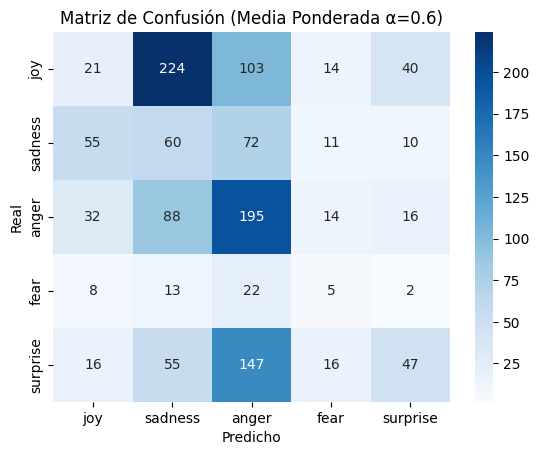


 Promedio ponderado con α = 0.8
              precision    recall  f1-score   support

         joy       0.12      0.03      0.05       402
     sadness       0.14      0.32      0.19       208
       anger       0.35      0.60      0.44       345
        fear       0.09      0.12      0.10        50
    surprise       0.52      0.05      0.09       281

    accuracy                           0.24      1286
   macro avg       0.24      0.23      0.18      1286
weighted avg       0.27      0.24      0.19      1286



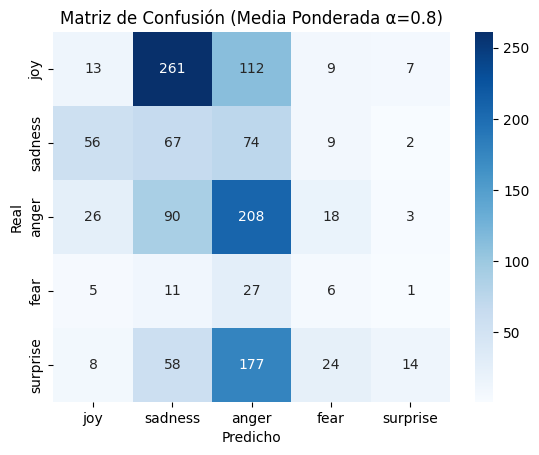

In [ ]:
def weighted_average_fusion(text_probs, audio_probs, alpha):
    fused_probs = alpha * text_probs + (1 - alpha) * audio_probs
    return np.argmax(fused_probs, axis=1)

for alpha in [0.2, 0.6, 0.8]:
    print(f"\n Promedio ponderado con α = {alpha}")
    # Reporte
    y_pred = weighted_average_fusion(text_probs, audio_probs, alpha=alpha)
    print(classification_report(mapped_labels, y_pred, target_names=MELD_LABELS))

    # Matriz de confusión
    cm = confusion_matrix(mapped_labels, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=MELD_LABELS, yticklabels=MELD_LABELS, cmap="Blues")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión (Media Ponderada α={alpha})")
    plt.show()

Fusión mediante regresión logística

In [ ]:
def load_and_process_split(csv_path, audio_dir, text_model, tokenizer, audio_model, extractor):
    df = pd.read_csv(csv_path)
    X_text, X_audio, y = [], [], []

    for _, row in df.iterrows():
        emotion = row["Emotion"]
        if emotion not in MELD_LABEL2ID:
            continue

        # Texto
        X_text.append(row["Utterance"])

        # Audio path
        file_name = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.wav"
        audio_path = os.path.join(audio_dir, file_name)
        X_audio.append(audio_path)

        # Etiqueta
        y.append(MELD_LABEL2ID[emotion])

    # Obtener probabilidades
    text_probs = get_text_probs(text_model, tokenizer, X_text)
    audio_probs = get_audio_probs(audio_model, extractor, X_audio)

    # Concatenar características
    X = np.hstack([text_probs, audio_probs])
    y = np.array(y)

    return X, y


              precision    recall  f1-score   support

         joy       0.48      0.75      0.59       402
     sadness       0.53      0.27      0.36       208
       anger       0.46      0.26      0.33       345
        fear       0.00      0.00      0.00        50
    surprise       0.42      0.54      0.47       281

    accuracy                           0.47      1286
   macro avg       0.38      0.36      0.35      1286
weighted avg       0.45      0.47      0.43      1286



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


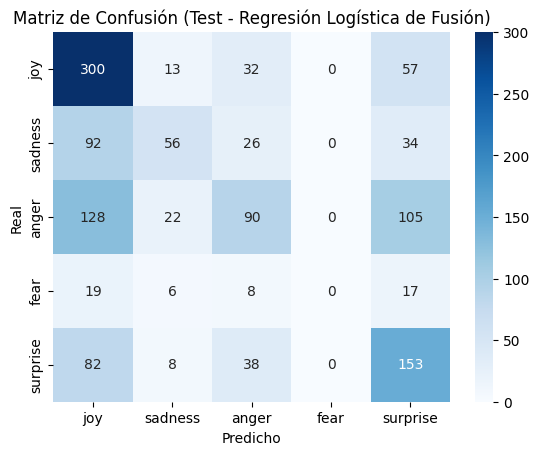

In [ ]:
# Rutas
CSV_TRAIN = "data/MELD_text/train_sent_emo.csv"
CSV_VAL = "data/MELD_text/dev_sent_emo.csv"
CSV_TEST = "data/MELD_text/test_sent_emo.csv"

# Cargar datos
X_train, y_train = load_and_process_split(CSV_TRAIN, os.path.join(AUDIO_DATA_DIR, "train"), text_model, tokenizer, audio_model, feature_extractor)
X_val, y_val = load_and_process_split(CSV_VAL, os.path.join(AUDIO_DATA_DIR, "dev"), text_model, tokenizer, audio_model, feature_extractor)
X_test, y_test = load_and_process_split(CSV_TEST, os.path.join(AUDIO_DATA_DIR, "test"), text_model, tokenizer, audio_model, feature_extractor)

# Combinar train + val
X_fusion_train = np.vstack([X_train, X_val])
y_fusion_train = np.concatenate([y_train, y_val])

# Entrenar regresión logística
fusion_model = LogisticRegression(max_iter=1000)
fusion_model.fit(X_fusion_train, y_fusion_train)

# Evaluar en test
y_pred = fusion_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=MELD_LABELS))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=MELD_LABELS, yticklabels=MELD_LABELS, cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión (Test - Regresión Logística de Fusión)")
plt.show()
